In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot
%matplotlib inline
plt.style.use('ggplot')

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import re
import tensorflow as tf


#train split and fit models
from nltk.tokenize import TweetTokenizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset = pd.read_csv('/kaggle/input/hateful-and-offensive-language/model_ready_combined.csv')
dataset.shape

In [ ]:
dataset.dropna(inplace=True)
dataset.drop_duplicates(inplace=True)
dataset.shape

In [ ]:
dataset.head()

### class values - 
+ label == 0 - Not Hateful/ Non-Risky
+ label == 1 - Potentially Risky 
+ label == 2 - hateful / Risky

In [ ]:
label_lst = ["Non-Risky", "Potentially Risky", "Risky"]

# Hybrid Model (BERT+LSTM)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split

# Load data
train = pd.read_csv('/kaggle/input/hatefull-and-offensive-language/train-data.csv')
test = pd.read_csv('/kaggle/input/hatefull-and-offensive-language/test-data.csv')
train.drop_duplicates(inplace=True)
test.dropna(inplace=True)
train.drop_duplicates(inplace=True)
test.dropna(inplace=True)


# Define BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


# Tokenize text data
MAX_LEN = 128
X_train_tokenized = tokenizer.batch_encode_plus(
    train['clean training'].tolist(),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False
)
X_test_tokenized = tokenizer.batch_encode_plus(
    test['clean training'].tolist(),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False
)

# Create input tensors
attention_masks = np.array(X_train_tokenized['attention_mask'])
X_train = np.array(X_train_tokenized['input_ids'])
X_test = np.array(X_test_tokenized['input_ids'])

y_train = np.array(train['label'])
y_test = np.array(test['label'])

# Split combined validation-test set into separate validation and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

# Define input layer for BERT model
input_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")

# Connect tokenizer output to BERT model
bert_output = bert_model(input_layer)[0]

# Define LSTM layer
reshape_layer = tf.keras.layers.Reshape((1, -1))(bert_output)
lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(reshape_layer)

# Define pooling layer
pooling_layer = GlobalMaxPooling1D()(lstm_layer)

# Define output layer
output_layer = Dense(3, activation='softmax')(pooling_layer)

# Define the model
model_1 = Model(inputs=[input_layer], outputs=[output_layer])

# Compile the model
model_1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])


# Train model
earlyStop = EarlyStopping(monitor='val_accuracy', patience=2, 
                        verbose=1, mode='max',restore_best_weights=True)

history = model_1.fit(
    x=X_train,
    y=tf.keras.utils.to_categorical(y_train),
    validation_data=(X_val, tf.keras.utils.to_categorical(y_val)),
    epochs=5,
    batch_size=16,
    callbacks=[earlyStop]
)

# Evaluate model on test set
batch_size = 16  # Set batch size to the same value as used in training
loss, accuracy = model_1.evaluate([X_test], tf.keras.utils.to_categorical(y_test, num_classes=3), batch_size=batch_size)
print('Test accuracy:', accuracy)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
6855/6855 [==============================] - 2043s 295ms/step - loss: 0.4898 - accuracy: 0.7876 - val_loss: 0.4017 - val_accuracy: 0.8235
Epoch 2/5
6855/6855 [==============================] - 2018s 294ms/step - loss: 0.3445 - accuracy: 0.8500 - val_loss: 0.3884 - val_accuracy: 0.8351
Epoch 3/5
6855/6855 [==============================] - 2020s 295ms/step - loss: 0.2628 - accuracy: 0.8823 - val_loss: 0.4109 - val_accuracy: 0.8292
Epoch 4/5
6855/6855 [==============================] - 2014s 294ms/step - loss: 0.2060 - accuracy: 0.9066 - val_loss: 0.4530 - val_accuracy: 0.8320
Epoch 4: early stopping
1905/1905 [==============================] - 203s 104ms/step - loss: 0.3796 - accuracy: 0.8413
Test accuracy: 0.8413313031196594


In [2]:
# Evaluate model on test set
batch_size = 16  # Set batch size to the same value as used in training
loss, accuracy = model_1.evaluate([X_test], tf.keras.utils.to_categorical(y_test, num_classes=3), batch_size=batch_size)
print('Test accuracy:', accuracy)

y_pred = model_1.predict(X_test)

y_pred = np.argmax(y_pred, axis=1) 

# Print Classification report
from sklearn.metrics import classification_report
print(f"\nClassification Report :\n{classification_report(y_test, y_pred)}")

1905/1905 [==============================] - 199s 105ms/step - loss: 0.3796 - accuracy: 0.8413
Test accuracy: 0.8413313031196594
953/953 [==============================] - 169s 173ms/step

Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      9794
           1       0.85      0.84      0.85     10406
           2       0.77      0.82      0.79     10266

    accuracy                           0.84     30466
   macro avg       0.84      0.84      0.84     30466
weighted avg       0.84      0.84      0.84     30466



In [3]:
# Make prediction on user input
text = 'This is a hateful and offensive message.'
text_tokenized = tokenizer.encode_plus(
    text,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False,
    return_tensors='tf'
)
prediction = model_1.predict([text_tokenized['input_ids'].numpy() ])

print('Prediction:', np.argmax(prediction))

1/1 [==============================] - 3s 3s/step
Prediction: 2


In [4]:
model_1.save("DL_model_Bart_Lstm.h5")

In [5]:
model_1.save("DL_model_Bart_Lstm_2.hdf5", include_optimizer=False)

## How to load the model : TFBertModel and include optimizer

In [2]:
from transformers import BertTokenizer, TFBertModel
from keras.models import load_model

from keras.optimizers import Adam

loaded_model = load_model("/kaggle/working/DL_model_Bart_Lstm_2.hdf5", custom_objects = {'TFBertModel': TFBertModel})

# Compile the model
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
loaded_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

# Load data
test = pd.read_csv('/kaggle/input/hatefull-and-offensive-language/test-data.csv')
test.dropna(inplace=True)
test.dropna(inplace=True)


# Define BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


# Tokenize text data
MAX_LEN = 128
X_test_tokenized = tokenizer.batch_encode_plus(
    test['clean training'].tolist(),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False
)

# Create input tensors
attention_masks = np.array(X_test_tokenized['attention_mask'])
X_test = np.array(X_test_tokenized['input_ids'])
y_test = np.array(test['label'])

batch_size = 16  # Set batch size to the same value as used in training

In [ ]:
# Evaluate model on test set
batch_size = 16  # Set batch size to the same value as used in training
loss, accuracy = model_1.evaluate([X_test], tf.keras.utils.to_categorical(y_test, num_classes=3), batch_size=batch_size)
print('Test accuracy:', accuracy)

y_pred = model_1.predict(X_test)

y_pred = np.argmax(y_pred, axis=1) 

# Print Classification report
from sklearn.metrics import classification_report
print(f"\nClassification Report :\n{classification_report(y_test, y_pred)}")

In [2]:
from transformers import BertTokenizer, TFBertModel

# Define BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

MAX_LEN = 128

# Make prediction on user input
text = 'I do not like differently abled'
text_tokenized = tokenizer.encode_plus(
    text,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False,
    return_tensors='tf'
)
prediction = loaded_model.predict([text_tokenized['input_ids'].numpy() ])
print(prediction)
print('Prediction:', np.argmax(prediction))

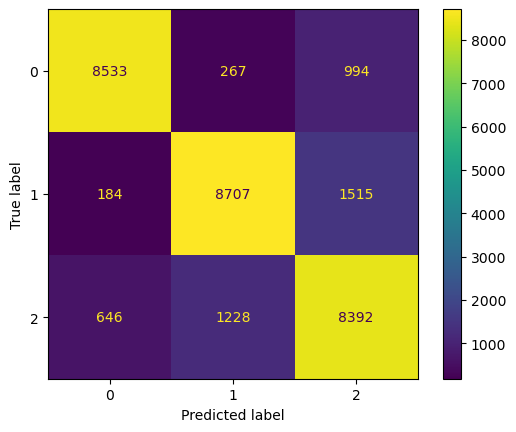

In [9]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

# DistilBert

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Load data
train = pd.read_csv('/kaggle/input/hatefull-and-offensive-language/train-data.csv')
test = pd.read_csv('/kaggle/input/hatefull-and-offensive-language/test-data.csv')
train.drop_duplicates(inplace=True)
test.dropna(inplace=True)
train.drop_duplicates(inplace=True)
test.dropna(inplace=True)

# Define BERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenize text data
MAX_LEN = 128
X_train_tokenized = tokenizer.batch_encode_plus(
    train['clean training'].tolist(),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False
)
X_test_tokenized = tokenizer.batch_encode_plus(
    test['clean training'].tolist(),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False
)

# Create input tensors
attention_masks = np.array(X_train_tokenized['attention_mask'])
X_train = np.array(X_train_tokenized['input_ids'])
X_test = np.array(X_test_tokenized['input_ids'])

y_train = np.array(train['label'])
y_test = np.array(test['label'])

# Define input layer for BERT model
input_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")

# Connect tokenizer output to BERT model
bert_output = bert_model(input_layer)[0]

# Define LSTM layer
lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(bert_output)

# Define pooling layer
pooling_layer = GlobalMaxPooling1D()(lstm_layer)

# Define output layer
output_layer = Dense(3, activation='softmax')(pooling_layer)

# Define the model
model = Model(inputs=[input_layer], outputs=[output_layer])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

# Train model
history = model.fit(
    x=X_train,
    y=y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=16,
    callbacks=[EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)]
)

# Evaluate model on test set
batch_size = 16  # Set batch size to the same value as used in training
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test accuracy:', accuracy)

# Use model to make predictions
text = 'This is a hateful tweet'
text_tokenized = tokenizer.encode_plus(
    text,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False
)
text_input = np.array(text_tokenized['input_ids']).reshape(1, -1)
prediction = model.predict(text_input)
predicted_label = np.argmax(prediction)
print('Predicted label:', predicted_label)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/5
6094/6094 [==============================] - 987s 160ms/step - loss: 0.5331 - accuracy: 0.7693 - val_loss: 0.4426 - val_accuracy: 0.8081
Epoch 2/5
6094/6094 [==============================] - 973s 160ms/step - loss: 0.3893 - accuracy: 0.8322 - val_loss: 0.4174 - val_accuracy: 0.8202
Epoch 3/5
6094/6094 [==============================] - 974s 160ms/step - loss: 0.3120 - accuracy: 0.8652 - val_loss: 0.4084 - val_accuracy: 0.8269
Epoch 4/5
1905/1905 [==============================] - 104s 55ms/step - loss: 0.4021 - accuracy: 0.8269
Test accuracy: 0.826921820640564
1/1 [==============================] - 2s 2s/step
Predicted label: 0


In [6]:

y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1) 

# Print Classification report
from sklearn.metrics import classification_report
print(f"\nClassification Report :\n{classification_report(y_test, y_pred)}")

953/953 [==============================] - 84s 88ms/step

Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      9794
           1       0.85      0.82      0.83     10406
           2       0.76      0.79      0.78     10266

    accuracy                           0.83     30466
   macro avg       0.83      0.83      0.83     30466
weighted avg       0.83      0.83      0.83     30466



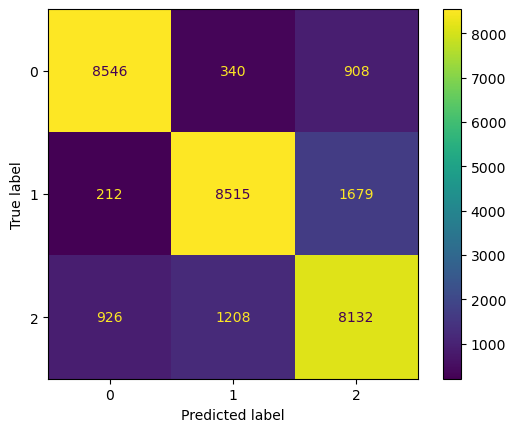

In [7]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [8]:
model.save("DL_model_DistilBert_Lstm.h5")

## How to load the model : TFDistilBertModel and include optimizer

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

test = pd.read_csv('/kaggle/input/hatefull-and-offensive-language/test-data.csv')
test.drop_duplicates(inplace=True)
test.dropna(inplace=True)
X_test = test['clean training']
y_test = test['label']

# Define BERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenize text data
MAX_LEN = 128
X_test_tokenized = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# Create input tensors
X_test = np.array(X_test_tokenized['input_ids'])
attention_masks = np.array(X_test_tokenized['attention_mask'])
y_test = np.array(y_test)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [1]:
from transformers import DistilBertTokenizer, TFDistilBertModel

# Evaluate model on test set
batch_size = 16  # Set batch size to the same value as used in training

from keras.models import load_model
loaded_model = load_model("/kaggle/working/DL_model_DistilBert_Lstm.h5", custom_objects = {'TFDistilBertModel': TFDistilBertModel})

# Evaluate model on test set
loss, accuracy = loaded_model.evaluate(X_test, y_test, batch_size=batch_size)

# Get predicted labels
y_pred = loaded_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Print Classification report
from sklearn.metrics import classification_report
print(f"\nClassification Report :\n{classification_report(y_test, y_pred)}")

In [ ]:
from transformers import BertTokenizer, TFBertModel

# Define BERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

MAX_LEN = 128

# Make prediction on user input
text = 'I do not like differently abled'
text_tokenized = tokenizer.encode_plus(
    text,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False,
    return_tensors='tf'
)
prediction = loaded_model.predict([text_tokenized['input_ids'].numpy() ])
print(prediction)
print('Prediction:', np.argmax(prediction))

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()